In [31]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as mplt
import xarray as xr
import xarray.plot as xplt
import pandas as pd
import bottleneck as bn
from ipywidgets import interact

ecv_base = 'D:\\EOData\\CCI-TBX'

## Step 1 - Read two ECVs
We read in 12 x monthly year of OC and SST at once

In [32]:
oc_pattern = os.path.join(ecv_base, 'occci-v2.0/data/geographic/netcdf/monthly/chlor_a/2010/*.nc')
st_pattern = os.path.join(ecv_base, 'sst/data/lt/Analysis/L4/v01.1/2010/*.nc')

oc_ds = xr.open_mfdataset(oc_pattern)
sst_ds = xr.open_mfdataset(st_pattern)

In [33]:
chla = oc_ds.chlor_a

In [34]:
chla

<xarray.DataArray 'chlor_a' (time: 12, lat: 4320, lon: 8640)>
dask.array<concate..., shape=(12, 4320, 8640), dtype=float64, chunksize=(1, 4320, 8640)>
Coordinates:
  * lon      (lon) float32 -179.979 -179.938 -179.896 -179.854 -179.813 ...
  * lat      (lat) float32 89.9792 89.9375 89.8958 89.8542 89.8125 89.7708 ...
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 2010-03-01 ...
Attributes:
    long_name: Chlorophyll-a concentration in seawater (not log-transformed), generated by SeaDAS using OC4v6 for SeaWiFS
    units: milligram m-3
    ancillary_variables: chlor_a_log10_rmsd,chlor_a_log10_bias
    grid_mapping: crs
    parameter_vocab_uri: http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name: mass_concentration_of_chlorophyll_a_in_sea_water
    units_nonstandard: mg m^-3

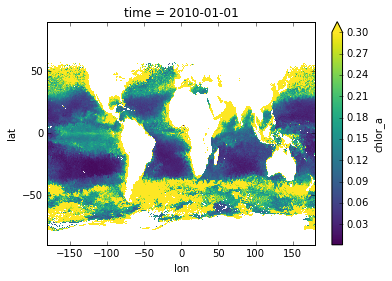

In [35]:
xplt.imshow(chla.isel(time=0), vmax=0.3)

In [36]:
sst = sst_ds.analysed_sst

xarray has a number of issues with SST data, see XXX

In [37]:
sst

<xarray.DataArray 'analysed_sst' (time: 12, lat: 3600, lon: 7200)>
dask.array<concate..., shape=(12, 3600, 7200), dtype=float64, chunksize=(1, 3600, 7200)>
Coordinates:
  * lat      (lat) float32 -89.975 -89.925 -89.875 -89.825 -89.775 -89.725 ...
  * lon      (lon) float32 -179.975 -179.925 -179.875 -179.825 -179.775 ...
  * time     (time) datetime64[ns] 1947-05-12T09:58:14 2015-05-05T15:22:30 ...
Attributes:
    units: kelvin
    long_name: analysed sea surface temperature
    valid_min: -300
    valid_max: 4500
    standard_name: sea_water_temperature
    depth: 20 cm
    source: ATSR<1,2>-ESACCI-L3U-v1.0, AATSR-ESACCI-L3U-v1.0, AVHRR<12,14,15,16,17,18>_G-ESACCI-L2P-v1.0, AVHRRMTA-ESACCI-L2P-v1.0
    comment: SST analysis produced for ESA SST CCI project using the OSTIA system in reanalysis mode.

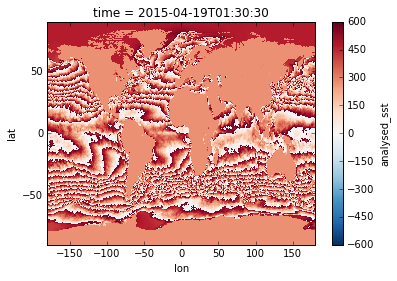

In [38]:
xr.plot.imshow(sst_ds.analysed_sst.isel(time=2))

## Step 2 - Geometric Adjustments
We make the OC data apply to spatial resolution of SST, because the latter is lower.

In [39]:
import scipy.ndimage

lat_factor = 3600./4320.
lon_factor = 7200./8640.

def resample(x):
    y = scipy.ndimage.zoom(x, [lat_factor, lon_factor])
    return xr.DataArray(y)
    
# Help! This is soooo slow... few minutes on Norman's PC
chla_temp = chla.groupby('time').apply(resample)
lon = scipy.ndimage.zoom(chla.lon, [lon_factor])
lat = scipy.ndimage.zoom(chla.lat, [lat_factor])
chla = xr.DataArray(chla_temp, dims=['time', 'lat', 'lon'], 
                    coords=dict(time=chla.time, lat=lat, lon=lon), attrs=chla.attrs)
chla

<xarray.DataArray (time: 12, lat: 3600, lon: 7200)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  na

## Step 3 - Spatial Subsetting

Note of OC data we have to supply lat slices in reverse order!

In [43]:
chla = chla.sel(lat=slice(45., 30.), lon=slice(-60., -45.))
chla

<xarray.DataArray (time: 12, lat: 0, lon: 300)>
array([], shape=(12, 0, 300), dtype=float64)
Coordinates:
  * lon      (lon) float32 -59.9764 -59.9264 -59.8764 -59.8264 -59.7764 ...
  * lat      (lat) float32 
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 2010-03-01 ...
Attributes:
    long_name: Chlorophyll-a concentration in seawater (not log-transformed), generated by SeaDAS using OC4v6 for SeaWiFS
    units: milligram m-3
    ancillary_variables: chlor_a_log10_rmsd,chlor_a_log10_bias
    grid_mapping: crs
    parameter_vocab_uri: http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name: mass_concentration_of_chlorophyll_a_in_sea_water
    units_nonstandard: mg m^-3

In [44]:
sst = sst.sel(lat=slice(30., 45.), lon=slice(-60., -45.))
sst

<xarray.DataArray 'analysed_sst' (time: 12, lat: 300, lon: 300)>
dask.array<getitem..., shape=(12, 300, 300), dtype=float64, chunksize=(1, 300, 300)>
Coordinates:
  * lat      (lat) float32 30.025 30.075 30.125 30.175 30.225 30.275 30.325 ...
  * lon      (lon) float32 -59.975 -59.925 -59.875 -59.825 -59.775 -59.725 ...
  * time     (time) datetime64[ns] 1947-05-12T09:58:14 2015-05-05T15:22:30 ...
Attributes:
    units: kelvin
    long_name: analysed sea surface temperature
    valid_min: -300
    valid_max: 4500
    standard_name: sea_water_temperature
    depth: 20 cm
    source: ATSR<1,2>-ESACCI-L3U-v1.0, AATSR-ESACCI-L3U-v1.0, AVHRR<12,14,15,16,17,18>_G-ESACCI-L2P-v1.0, AVHRRMTA-ESACCI-L2P-v1.0
    comment: SST analysis produced for ESA SST CCI project using the OSTIA system in reanalysis mode.

## Step 5 - Correlation Analysis

See:
* http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.apply_along_axis.html
* http://xarray.pydata.org/en/stable/generated/xarray.DataArray.reduce.html?highlight=reduce#xarray.DataArray.reduce

In [46]:
def cov(a, b):   
    #print(a.shape)
    x = (a - bn.nanmean(a)) * (b - bn.nanmean(b))
    n = np.count_nonzero(np.isnan(x))
    return bn.nansum(x) / n if n > 0 else np.nan

def autocov(x, lag):
    #print(x, type(x))
    a = x[:-lag]
    b = x[lag:]
    return cov(a, b)
    
def myfunc(x, axis, **kwargs):
    #print(x.shape, axis)
    res = np.apply_along_axis(autocov, axis, x, 1)
    #print(res.shape)
    return res

chla_auto_corr = chla.reduce(myfunc, dim='time', keep_attrs=True)

IndexError: index 0 is out of bounds for axis 1 with size 0

In [13]:
plot.imshow(chla_auto_corr)

NameError: name 'plot' is not defined